# Trabajo Práctico 2: Reseñas de Películas - Random Forest

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_palette('colorblind')

 # Carga de datos

Carga del dataset de entrenamiento anteriormente preprocesado. En este caso, a diferencia de lo que pasó con la red neuronal y XGBoost, obtuvimos mejores resultados con el dataset con preprocesamiento más complejo, que incluye un análisis de part-of-speech como el utilizado con Naive Bayes y además cuenta con columnas que cuentan la cantidad de negaciones en cada crítica, la cantidad de adjetivos negativos y la cantidad de signos de exclamación.

In [2]:
df = pd.read_csv("../datasets/train-complejo.csv", index_col=0)
df.head()

,texto_preprocesado,num_neg,num_adj_neg,num_exclm,lang,sentimiento
ID,,,,,,
0,critico_NOUN mencionar_VERB oz_DET episodio_NO...,7,4,0,es,positivo
1,pequén_ADJ pequén_ADJ produccion_PROPN tecnica...,2,0,2,es,positivo
2,pense_VERB maravilloso_ADJ pasar_VERB tiempo_N...,2,0,1,es,positivo
3,basicamente_ADV familia_NOUN nino_NOUN pequeno...,0,0,4,es,negativo
4,amor_NOUN tiempo_NOUN pelicula_NOUN visualment...,1,2,0,es,positivo


In [3]:
from sklearn.model_selection import train_test_split

feature_cols = ["texto_preprocesado", "num_neg", "num_adj_neg", "num_exclm"]

X = df[feature_cols]
y = df["sentimiento"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

# Preparación de datos

En este caso obtuvimos mejores resultados utilizando ngramas de un rango de 1 a 2 y decidimos limitar la frecuencia máxima para directamente descartar las palabras muy repetidas en todo el corpus. También vamos a utilizar las features numéricas, por lo que decidimos escalar los valores para darles igual peso a todas las columnas.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

tfidf = TfidfVectorizer(ngram_range=(1, 2), strip_accents="unicode", min_df=20, max_df=0.9)
scaler = StandardScaler()

ct = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, feature_cols[0]),
        ("scaler", scaler, feature_cols[1:]),
    ],
    remainder="drop",
)

le = LabelEncoder()

In [5]:
X_train_trans = ct.fit_transform(X_train)
X_val_trans = ct.transform(X_val)
X_test_trans = ct.transform(X_test)

# Entrenamiento del modelo

Los parámetros fueron en primera instancia buscados con RandomizedSearchCV, obteniendo un modelo con mucho overfitting. Con lo cual, se optó por modificar algunos de los parámetros manualmente para reducir ese overfit. Finalmente la mejor combinación a la que llegamos fue la siguiente:

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf = RandomForestClassifier(
    n_estimators=1000,
    criterion="gini",
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=8,
    oob_score=True,
    n_jobs=-1,
)

rf.fit(X_train_trans, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=1000, n_jobs=-1, oob_score=True)

In [7]:
rf

RandomForestClassifier(max_depth=15, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=1000, n_jobs=-1, oob_score=True)

Quizá el hyperparámetro que más llama la atención es la cantidad de estimadores que utiliza el random forest. Terminamos llegando a valores tan elevados de este parámetro ya que al ir ajustando los parámetros para evitar el overfitting, también iba decreciendo la capacidad del modelo para obtener información de los datos, por lo que todos los parámetros de regularización terminan requiriendo que se incremente la cantidad de árboles en el forest para poder lograr un balance.

In [8]:
from sklearn.metrics import classification_report

y_pred_train = rf.predict(X_train_trans)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

    negativo       0.88      0.79      0.84     16000
    positivo       0.81      0.90      0.85     16000

    accuracy                           0.84     32000
   macro avg       0.85      0.84      0.84     32000
weighted avg       0.85      0.84      0.84     32000



In [9]:
y_pred_val = rf.predict(X_val_trans)

print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

    negativo       0.86      0.77      0.81      4000
    positivo       0.79      0.87      0.83      4000

    accuracy                           0.82      8000
   macro avg       0.83      0.82      0.82      8000
weighted avg       0.83      0.82      0.82      8000



In [10]:
y_pred_test = rf.predict(X_test_trans)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

    negativo       0.86      0.77      0.81      5000
    positivo       0.79      0.87      0.83      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



Vemos que el mejor modelo probado hace un buen trabajo prediciendo los resultados, pero que en el caso de las críticas negativas el recall es un poco más bajo que la precision, esto se puede evidenciar mejor si utilizamos una matriz de confusión.

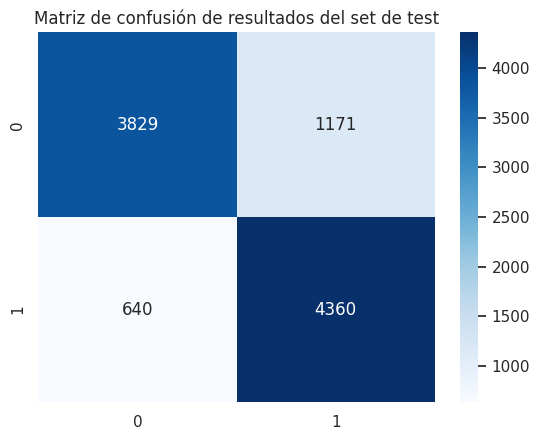

In [11]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred_test), cmap='Blues', annot=True, fmt='g').set(title='Matriz de confusión de resultados del set de test')
plt.show()

Como podemos observar, en general el modelo hace un buen trabajo prediciendo datos nuevos, sin embargo el número de falsos positivos y negativos está un poco desbalanceado. Sin embargo, decidimos conservar esta versión del modelo ya que, comparada con las otras que probamos, nos daba el mejor balance entre valores de las métricas y overfitting.

# Predicciones sobre el dataset de testing de la competencia

Finalmente hacemos las predicciones para la competencia de Kaggle. Para esto reentrenamos el modelo final con todo el dataset de train.

In [12]:
import copy

ct_final = copy.deepcopy(ct)

X_final_trans = ct_final.fit_transform(df[feature_cols])
y_final = df["sentimiento"]

rf.fit(X_final_trans, y_final)

RandomForestClassifier(max_depth=15, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=1000, n_jobs=-1, oob_score=True)

In [14]:
df_kaggle = pd.read_csv("../datasets/test-complejo.csv", index_col=0)
df_kaggle["sentimiento"] = rf.predict(ct_final.transform(df_kaggle[feature_cols]))
df_kaggle["sentimiento"]

ID
60000    negativo
60001    negativo
60002    negativo
60003    negativo
60004    positivo
           ...   
68594    positivo
68595    positivo
68596    positivo
68597    negativo
68598    negativo
Name: sentimiento, Length: 8599, dtype: object

In [15]:
df_kaggle["sentimiento"].to_csv("../predicciones/random-forest-final.csv")

# Guardado del Modelo

Exportamos el modelo para que pueda ser utilizado nuevamente sin necesidad de ser re-entrenado.

In [16]:
from joblib import dump

dump(rf, '../modelos/random-forest.joblib', compress=True)

['../modelos/random-forest.joblib']